In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pprint import pprint
import pandas as pd
import numpy as np
import eli5
import time
from sklearn.model_selection import cross_validate
import img_utils

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [9]:
sizes = [1, 2, 4, 8, 16, 32, 64, 128]

def get_features(sample, col_names):
    features = {col_names[i+1]: float(sample[i]) for i in range(sample.shape[0])}
    features['bias'] = 1.0
    return features


In [10]:
metrics_crf = {label: {'mean':[], 'std':[]} for label in ['fit_time', 'score_time', 'test_score', 'train_score']}

for size in sizes:
    np.random.seed(42)
    data = pd.read_csv(f'data/resized_data_scaled_{size}.csv')
    col_names = data.columns
    
    Y = [[str(int(y[0]))] for y in data[['y']].values.astype(np.uint8)]
    X = data[col_names[1:]].values
    
    X = [[get_features(X[i], col_names)] for i in range(X.shape[0])]
    
    model = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )
    
    metrics = {'fit_time':[], 'score_time':[], 'train_score':[], 'test_score':[]}
    for i in range(3):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
        start = time.time()
        model.fit(X_train, y_train)
        metrics['fit_time'].append(time.time() - start)
        metrics['train_score'].append(model.score(X_train, y_train))
        start = time.time()
        metrics['test_score'].append(model.score(X_test, y_test))
        metrics['score_time'].append(time.time() - start)
    
    print(len(model.state_features_))     

    pprint(metrics)
    for key in metrics:
        metrics_crf[key]['mean'].append(np.array(metrics[key]).mean())
        metrics_crf[key]['std'].append(np.array(metrics[key]).std())

16
{'fit_time': [0.35744285583496094, 0.37772083282470703, 0.39014506340026855],
 'score_time': [0.00710296630859375,
                0.004300117492675781,
                0.004395961761474609],
 'test_score': [0.5561674008810573, 0.5969162995594713, 0.5781938325991189],
 'train_score': [0.5874142997061704, 0.6019833496571988, 0.5893731635651323]}
52
{'fit_time': [0.5521080493927002, 0.5277590751647949, 0.5459277629852295],
 'score_time': [0.007551908493041992,
                0.006394863128662109,
                0.0063800811767578125],
 'test_score': [0.6387665198237885, 0.6200440528634361, 0.6222466960352423],
 'train_score': [0.6291625857002938, 0.6280607247796278, 0.628305582761998]}
196
{'fit_time': [1.256761074066162, 1.2894196510314941, 1.3773071765899658],
 'score_time': [0.014501810073852539,
                0.014573097229003906,
                0.01446390151977539],
 'test_score': [0.6872246696035242, 0.6949339207048458, 0.7015418502202643],
 'train_score': [0.69245837414299

In [11]:
crf_df = pd.DataFrame.from_dict({f'{label}_{sub_label}': metrics_crf[label][sub_label] 
                                 for label in metrics_crf for sub_label in metrics_crf[label]})
crf_df = crf_df.rename({i: 2**i for i in range(9)}, axis='index')
crf_df.to_csv('crf_data.csv')

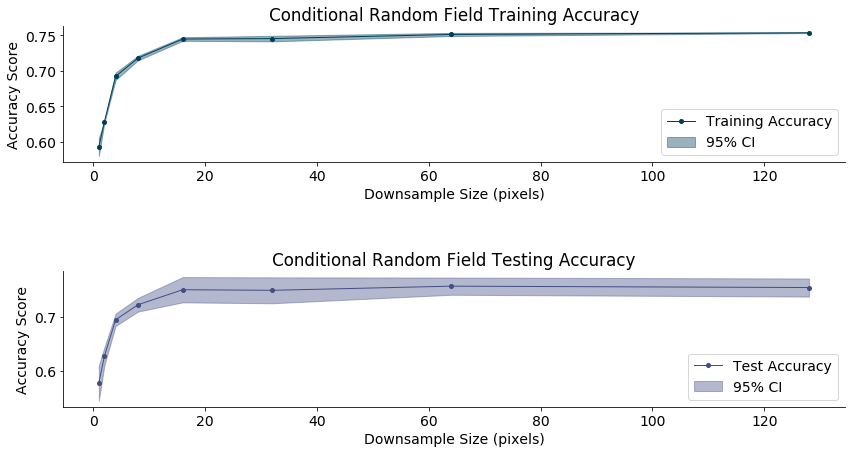

In [20]:
fig, axs = img_utils.make_subplot(rows=2, cols=1)
img_utils.lineplot_ci(axs[0], crf_df.index, 
                   list(crf_df['train_score_mean']), list(crf_df['train_score_std']), 
                   label="Training Accuracy", title="Conditional Random Field Training Accuracy",
                   x_label="Downsample Size (pixels)", y_label="Accuracy Score",
                   color=0)
img_utils.lineplot_ci(axs[1], crf_df.index, 
                   list(crf_df['test_score_mean']), list(crf_df['test_score_std']), 
                   label="Test Accuracy", title="Conditional Random Field Testing Accuracy",
                   x_label="Downsample Size (pixels)", y_label="Accuracy Score",
                   color=1)
plt.subplots_adjust(hspace = 0.8)
plt.savefig('../report/crf_graph_score.png', dpi=300, bbox_inches='tight')

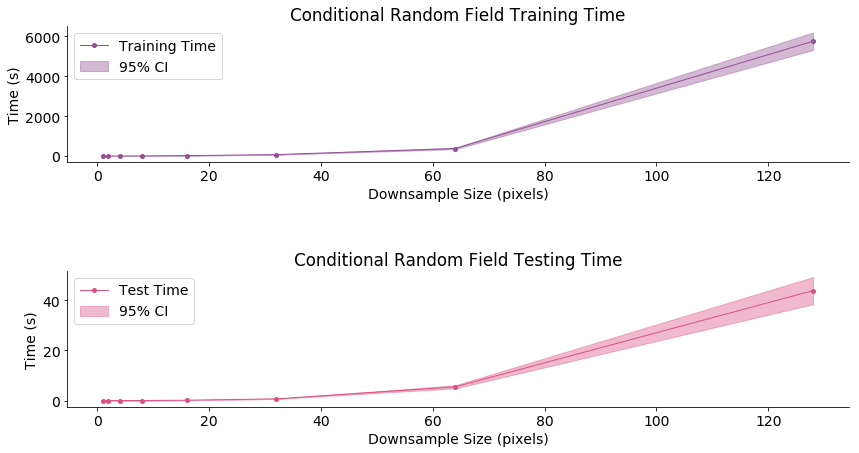

In [21]:
fig, axs = img_utils.make_subplot(rows=2, cols=1)
img_utils.lineplot_ci(axs[0], crf_df.index, 
                   list(crf_df['fit_time_mean']), list(crf_df['fit_time_std']), 
                   label="Training Time", title="Conditional Random Field Training Time",
                   x_label="Downsample Size (pixels)", y_label="Time (s)",
                   color=2, loc="upper left")
img_utils.lineplot_ci(axs[1], crf_df.index, 
                   list(crf_df['score_time_mean']), list(crf_df['score_time_std']), 
                   label="Test Time", title="Conditional Random Field Testing Time",
                   x_label="Downsample Size (pixels)", y_label="Time (s)",
                   color=3, loc="upper left")
plt.subplots_adjust(hspace = 0.8)
plt.savefig('../report/crf_graph_time.png', dpi=300, bbox_inches='tight')

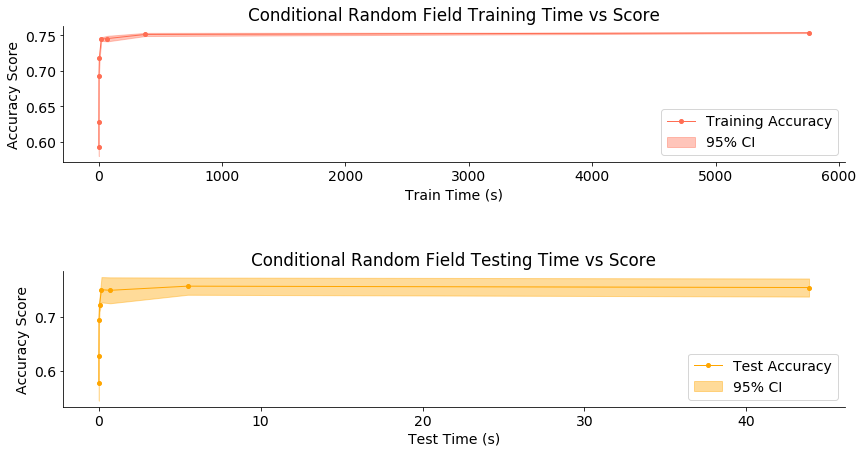

In [22]:
fig, axs = img_utils.make_subplot(rows=2, cols=1)
img_utils.lineplot_ci(axs[0], list(crf_df['fit_time_mean']), 
                   list(crf_df['train_score_mean']), list(crf_df['train_score_std']), 
                   label="Training Accuracy", title="Conditional Random Field Training Time vs Score",
                   x_label="Train Time (s)", y_label="Accuracy Score",
                   color=4)
img_utils.lineplot_ci(axs[1], list(crf_df['score_time_mean']), 
                   list(crf_df['test_score_mean']), list(crf_df['test_score_std']), 
                   label="Test Accuracy", title="Conditional Random Field Testing Time vs Score",
                   x_label="Test Time (s)", y_label="Accuracy Score",
                   color=5)
plt.subplots_adjust(hspace = 0.8)
plt.savefig('../report/crf_graph_time_score.png', dpi=300, bbox_inches='tight')